## Accessing MODIS fire data with the Planetary Computer STAC API

The planetary computer hosts three fire-related MODIS 6.1 products:

- Thermal Anomalies/Fire Daily (14A1) 
- Thermal Anomalies/Fire 8-Day (14A2)
- Burned Area Monthly (64A1)

For more information about the products themselves, check out the User Guide at the [bottom of this document](#user-guides).

### Environment setup

This notebook works with or without an API key, but you will be given more permissive access to the data with an API key.
The Planetary Computer Hub is pre-configured to use your API key.

In [1]:
from geogif import gif
import odc.stac
import planetary_computer
import pystac_client
import rich.table

### Data access

The datasets hosted by the Planetary Computer are available from [Azure Blob Storage](https://docs.microsoft.com/en-us/azure/storage/blobs/). We'll use [pystac-client](https://pystac-client.readthedocs.io/) to search the Planetary Computer's [STAC API](https://planetarycomputer.microsoft.com/api/stac/v1/docs) for the subset of the data that we care about, and then we'll load the data directly from Azure Blob Storage. We'll specify a `modifier` so that we can access the data stored in the Planetary Computer's private Blob Storage Containers. See [Reading from the STAC API](https://planetarycomputer.microsoft.com/docs/quickstarts/reading-stac/) and [Using tokens for data access](https://planetarycomputer.microsoft.com/docs/concepts/sas/) for more.

In [2]:
catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)

### Query for available data

MODIS is a global dataset with a variety of products available within each larger category (vegetation, snow, fire, temperature, and reflectance). The [MODIS group](https://planetarycomputer.microsoft.com/dataset/group/modis) contains a complete listing of available collections. Each collection's format follows`modis-{product}-061`, where `product` is the MODIS product id. The `-061` suffix indicates that all of the MODIS collections are part of the [MODIS 6.1 update](https://atmosphere-imager.gsfc.nasa.gov/documentation/collection-61).

Let's access Thermal Anomalies/Fire 8-Day 1km (14A2) data for the 2021 Dixie Wildfire in California. The wildfire extents included Butte, Plumas, Lassen, Shasta, and Tehama counties and burned approximately 936,309 acres. 

In [3]:
# 2021 Dixie Wildfire in California
latitude = 40.7310
longitude = -122.9420
location = [longitude, latitude]
geometry = {
    "type": "Point",
    "coordinates": location,
}
datetimes = [
    "2021-07-12",
    "2021-07-20",
    "2021-07-28",
    "2021-08-05",
    "2021-08-13",
    "2021-08-21",
]

buffer = 0.7
bbox = [longitude - buffer, latitude - buffer, longitude + buffer, latitude + buffer]
items = dict()

# Fetch the collection of interest and print availabe items
for datetime in datetimes:
    print(f"Fetching {datetime}")
    search = catalog.search(
        collections=["modis-14A2-061"],
        intersects=geometry,
        datetime=datetime,
    )
    items[datetime] = search.get_all_items()[0]

print(items)

Fetching 2021-07-12
Fetching 2021-07-20
Fetching 2021-07-28
Fetching 2021-08-05
Fetching 2021-08-13
Fetching 2021-08-21
{'2021-07-12': <Item id=MYD14A2.A2021193.h08v04.061.2021202231138>, '2021-07-20': <Item id=MYD14A2.A2021201.h08v04.061.2021210025058>, '2021-07-28': <Item id=MYD14A2.A2021209.h08v04.061.2021218015513>, '2021-08-05': <Item id=MYD14A2.A2021217.h08v04.061.2021226035858>, '2021-08-13': <Item id=MYD14A2.A2021225.h08v04.061.2021234033430>, '2021-08-21': <Item id=MYD14A2.A2021233.h08v04.061.2021243064108>}


### Available Assets

Each item has several available assets, including the original HDF file and a Cloud-optimized GeoTIFF of each subdataset.

In [4]:
t = rich.table.Table("Key", "Title")
for key, asset in items["2021-07-12"].assets.items():
    t.add_row(key, asset.title)
t

┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Key              ┃ Title                                             ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ QA               │ Pixel quality indicators                          │
│ hdf              │ Source data containing all bands                  │
│ FireMask         │ Confidence of fire                                │
│ metadata         │ Federal Geographic Data Committee (FGDC) Metadata │
│ tilejson         │ TileJSON with default rendering                   │
│ rendered_preview │ Rendered preview                                  │
└──────────────────┴───────────────────────────────────────────────────┘

### Loading the fire mask data


For this example, we'll visualize the fire mask throughtout the peak of the 2021 Dixie Wildfire in California. Let's grab each fire mask cover COG and load them into an xarray using [odc-stac](https://github.com/opendatacube/odc-stac). The MODIS coordinate reference system is a [sinusoidal grid](https://modis-land.gsfc.nasa.gov/MODLAND_grid.html), which means that views in a naïve XY raster look skewed. For visualization purposes, we reproject to a [spherical Mercator projection](https://wiki.openstreetmap.org/wiki/EPSG:3857) for intuitive, north-up visualization.

The fire mask values are defined as:

    0: Not processed (missing input data)
    1: Not processed (obsolete; not used since Collection 1)
    2: Not processed (other reason)
    3: Non-fire water pixel
    4: Cloud (land or water)
    5: Non-fire land pixel
    6: Unknown (land or water)
    7: Fire (low confidence, land or water)
    8: Fire (nominal confidence, land or water)
    9: Fire (high confidence, land or water)

In [5]:
data = odc.stac.load(
    items.values(),
    crs="EPSG:3857",
    bbox=bbox,
    bands="FireMask",
    resolution=1000,
)
data = data.where(data < 10, drop=True)
data

<xarray.Dataset>
Dimensions:      (time: 6, y: 207, x: 157)
Coordinates:
  * y            (y) float64 5.076e+06 5.076e+06 ... 4.872e+06 4.870e+06
  * x            (x) float64 -1.376e+07 -1.376e+07 ... -1.361e+07 -1.361e+07
    spatial_ref  int32 3857
  * time         (time) datetime64[ns] 2021-07-12 2021-07-20 ... 2021-08-21
Data variables:
    FireMask     (time, y, x) float64 5.0 5.0 5.0 5.0 5.0 ... 5.0 5.0 5.0 5.0

### Displaying the data
Let's display the fire mask from 07-08-2021 through 08-21-2021.

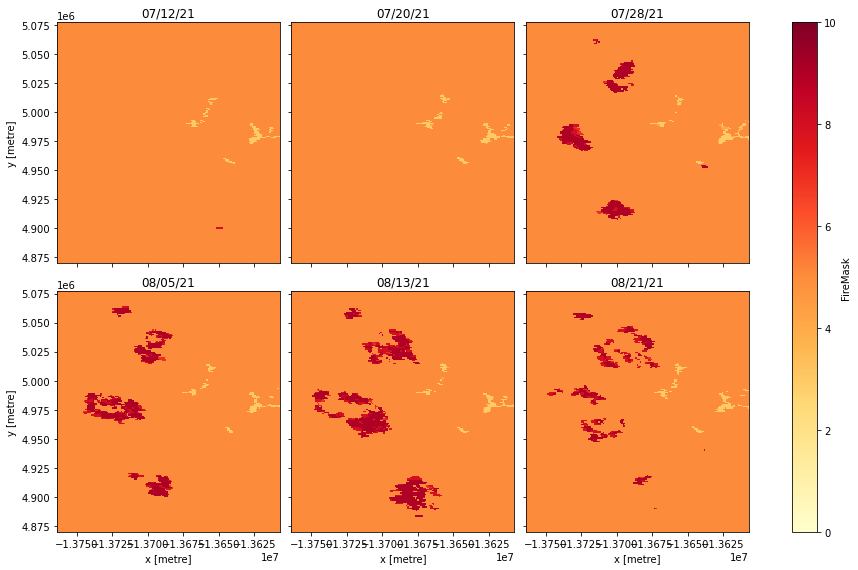

In [6]:
g = data["FireMask"].plot.imshow(
    cmap="YlOrRd", col="time", vmin=0, vmax=10, col_wrap=3, size=4
)
datetimes = data["FireMask"].time.to_pandas().dt.strftime("%D")

for ax, datetime in zip(g.axes.flat, datetimes):
    ax.set_title(datetime)

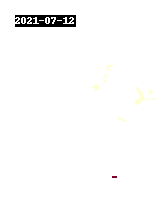

In [7]:
data = data.where(data < 9)
gif(data.FireMask, fps=3, cmap="YlOrRd")

### User guides

- MOD14: https://lpdaac.usgs.gov/documents/1005/MOD14_User_Guide_V61.pdf